In [ ]:
import os
import json
from PIL import Image, ImageDraw
import re
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from skimage.exposure import equalize_adapthist
from scipy.stats import stats
import matplotlib.animation as animation
import pandas as pd
import csv
import shutil
from skimage.morphology import dilation, erosion
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import measure

from skimage.measure import regionprops, label


/tmp/ipykernel_2835091/3592591493.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


Labels from the mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Cell 1: {'Area': 131235.0, 'Perimeter': 6183.306745292798, 'Solidity': 0.42635205598276854, 'Extent': 0.28146071753341456, 'Circularity': 0.04313382341489642, 'Convexity': 49.78064532126399, 'Elongation': 0.8096061194654044, 'Compactness': 0.3315370412176449}
Cell 2: {'Area': 77701.0, 'Perimeter': 2729.263022691402, 'Solidity': 0.6057518398403393, 'Extent': 0.3529040404040404, 'Circularity': 0.1310827940070075, 'Convexity': 46.99876814126453, 'Elongation': 0.8269531745933486, 'Compactness': 0.3442173806879633}
Cell 3: {'Area': 28925.0, 'Perimeter': 923.208152801713, 'Solidity': 0.8272085108816885, 'Extent': 0.5232642280835051, 'Circularity': 0.4264655647579396, 'Convexity': 37.87553207137917, 'Elongation': 0.5061880943980945, 'Compactness': 0.651261919376675}
Cell 4: {'Area': 38932.0, 'Perimeter': 3029.280266634105, 'Solidity': 0.2907456087943601, 'Extent': 0.1904622

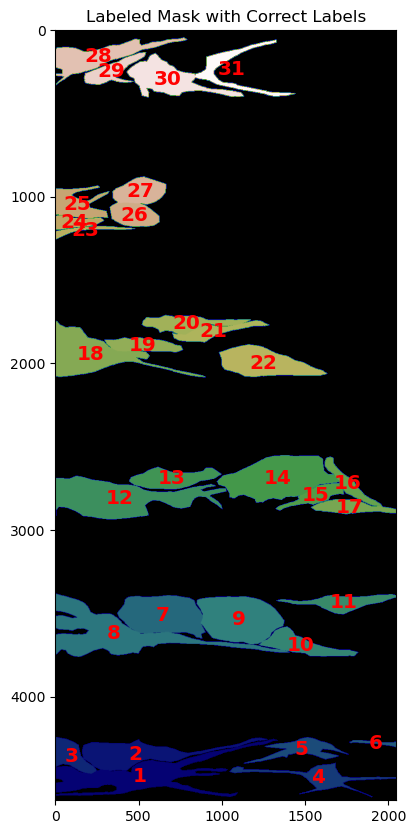

In [ ]:
def analyze_mask_with_shape_factors(frame, mask_path_template, size_threshold=1000):
    

    def plot_labels(original, ax, title=None,
                    txt_args={'color': 'red', 'ha': 'center', 'va': 'center',
                              'fontsize': 'x-large', 'fontweight': 'bold'},
                    cmap='gist_earth'):
        ax.imshow(original, cmap=cmap)
        labels = np.unique(original)
        print("Labels in plot_labels function:", labels)
        ax.set_title(title)
        for label in labels:
            if label != 0:  # Skip background label
                inds = np.argwhere(original == label)
                loc = inds.mean(0)
                ax.text(loc[1], loc[0], str(label), **txt_args)

    def calculate_shape_factors(region):
        """Calculate shape factors for a single region."""
        area = region.area
        perimeter = region.perimeter
        convex_area = region.convex_area
        bounding_box_area = region.bbox_area
        
        solidity = area / convex_area if convex_area > 0 else 0
        extent = area / bounding_box_area if bounding_box_area > 0 else 0
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        convexity = region.convex_image.sum() / perimeter if perimeter > 0 else 0
        
        min_diameter = region.minor_axis_length
        max_diameter = region.major_axis_length
        elongation = 1 - (min_diameter / max_diameter) if max_diameter > 0 else 0
        
        compactness = (np.sqrt(4 * area / np.pi)) / max_diameter if max_diameter > 0 else 0

        return {
            "Area": area,
            "Perimeter": perimeter,
            "Solidity": solidity,
            "Extent": extent,
            "Circularity": circularity,
            "Convexity": convexity,
            "Elongation": elongation,
            "Compactness": compactness,
        }

    # Load the mask image using imageio
    mask_path = mask_path_template.format(frame=frame)
    mask = imageio.imread(mask_path)

    # Print the labels directly from the mask
    unique_labels = np.unique(mask)
    print("Labels from the mask:", unique_labels)

    # Measure the properties of the labeled regions
    properties = regionprops(mask)

    # Apply a size threshold to filter out small artifacts
    filtered_regions = [prop for prop in properties if prop.label != 0 and prop.area >= size_threshold]

    # Calculate shape factors for filtered regions
    shape_factors_list = [calculate_shape_factors(region) for region in filtered_regions]

    # Display the results
    for idx, factors in enumerate(shape_factors_list):
        print(f"Cell {idx + 1}: {factors}")

    # Plot the labels for filtered cells, excluding the background label
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_labels(mask, ax, title="Labeled Mask with Correct Labels")
    plt.show()

# Example usage
frame = 55
# mask_path_template = "/path/to/mask_{frame:04d}.tif"  # Update the path
mask_path_template = "/home/MinaHossain/DMNet_Rina/training_codes/Data/train/Cell-Data-P2/02_GT/SEG/man_seg{frame:04d}.tif"
analyze_mask_with_shape_factors(frame, mask_path_template)
